In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
% cd /content/gdrive/MyDrive/Data Science/Dataset/Final Project

/content/gdrive/MyDrive/Data Science/Dataset/Final Project


# Import Pustaka

In [21]:
import os
import glob
import string
import pathlib

import pandas as pd
import numpy as np
import tensorflow as tf
import random

from numpy import array
from pickle import dump, load
from time import time
from keras import Input, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from keras.applications.inception_v3 import preprocess_input

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.applications.inception_v3 import InceptionV3
import cv2

In [22]:
data_dir = pathlib.Path("Images")

In [23]:
def load_doc(file):
  file = open(filename, 'r')
  doc = file.read()
  file.close()
  return doc

In [24]:
filename = "Flickr8k.token.txt"
doc = load_doc(filename)
print(doc[:200])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A lit


# Load Description of Image

In [25]:
#Load Description of image
def load_description(doc):
  #Load list of train photo identifiers
  description = dict()
  #Iterate every line
  for line in doc.split('\n'):
    #split by white space
    token = line.split()
    
    if len(line) < 2:
      continue

    #first token as name of image, rest as description of an image
    image_id, desc = token[0], token[1:]

    #get only name of an img without .jpg
    image_id = image_id.split('.')[0]
    image_desc = " ".join(desc)

    if image_id not in description:
      description[image_id] = list()
    description[image_id].append(image_desc)
  return description

In [26]:
desc = load_description(doc)
print("Data Description Loaded:", len(desc))

Data Description Loaded: 8092


In [27]:
# Generate 1 image description
print(list(desc.keys())[0])
desc[list(desc.keys())[0]]

1000268201_693b08cb0e


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [28]:
#Load Training Image with specific features
def load_specific_image(doc):
  #Load list of train photo identifiers
  description = dict()
  specific_features = ['beach', 'mountain', 'forest', 'sea', 'lake', 'river', 
                       'cave', 'garden', 'field', 'cliff', 'ocean', 'woods',
                       'jungle']
  #Iterate every line
  for line in doc.split('\n'):
    #split by white space
    token = line.split()
    
    if len(line) < 2:
      continue

    #first token as name of image, rest as description of an image
    image_id, desc = token[0], token[1:]

    #get only name of an img without .jpg
    image_id = image_id.split('.')[0]
    image_desc = " ".join(desc)

    if any(x in image_desc for x in specific_features):
      if image_id not in description:
        description[image_id] = list()
      
      description[image_id].append(image_desc)
  return description

In [29]:
specific_img = load_specific_image(doc)
print("Specific Image Loaded:", len(specific_img))

Specific Image Loaded: 2292


# Preprocess caption in Description

In [30]:
def clean_description(description):
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in description.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      #token
      desc = desc.split()
      #lowercase
      desc = [word.lower() for word in desc]
      #remove punctuation from token
      desc = [w.translate(table) for w in desc]
      #remove single word like 's and a
      desc = [word for word in desc if len(word)>1]
      #remove tokens with number
      desc = [word for word in desc if word.isalpha()]
      desc_list[i] = ' '.join(desc)

clean_description(desc)
# clean_description(specific_img)

In [31]:
# make a vocabulary from description

def to_vocab(description):
  all_desc = set()
  for key in description.keys():
    [all_desc.update(d.split()) for d in description[key]]
  return all_desc

vocabulary = to_vocab(desc)
# vocabulary = to_vocab(specific_img)
print('Vocabulary :', len(vocabulary))

Vocabulary : 8763


# Load Images

In [32]:
img_dir = 'Images/'
img = glob.glob(img_dir + '*.jpg')

In [33]:
train_img_file = "Flickr_8k.trainImages.txt"
train_image = set(open(train_img_file, 'r').read().strip().split('\n'))

train_img = []
# for i in list(train_data):
#   x = img_dir + i +'.jpg'
#   train_img.append(x)

for i in img:
  if i[len(img_dir):] in train_image:
    train_img.append(i)

print("Data original for train:",len(train_img))

Data original for train: 6000


In [34]:
test_img_file = "Flickr_8k.testImages.txt"
test_image = set(open(test_img_file, 'r').read().strip().split('\n'))

test_img = list()
# for i in list(test_data):
#   x = img_dir + i +'.jpg'
#   test_img.append(x)

for i in img:
  if i[len(img_dir):] in test_image:
    test_img.append(i)

print("Data original for test:",len(test_img))

Data original for test: 1000


# Filter Dataset for specific case

In [35]:
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

In [36]:
train_data = load_clean_descriptions(specific_img, train_image)
print("Train Data :",len(train_data))

Train Data : 1701


In [37]:
test_data =  load_clean_descriptions(specific_img, test_image)
print("Test Data:", len(test_data))

Test Data: 302


In [38]:
# Image for train and Test (Filtered)
new_train_img = []
new_test_img = []

for i in list(train_data):
  x = img_dir + i +'.jpg'
  new_train_img.append(x)

for i in list(test_data):
  x = img_dir + i +'.jpg'
  new_test_img.append(x)

In [43]:
list(test_data.keys())

['106490881_5a2dd9b7bd',
 '1082379191_ec1e53f996',
 '1119015538_e8e796281e',
 '113678030_87a6a6e42e',
 '1174525839_7c1e6cfa86',
 '1248940539_46d33ed487',
 '1298295313_db1f4c6522',
 '1311388430_4ab0cd1a1f',
 '1322323208_c7ecb742c6',
 '1343426964_cde3fb54e8',
 '1352410176_af6b139734',
 '136552115_6dc3e7231c',
 '136886677_6026c622eb',
 '1386964743_9e80d96b05',
 '138718600_f430ebca17',
 '1392272228_cf104086e6',
 '1402640441_81978e32a9',
 '1408958345_68eea9a4e4',
 '143688283_a96ded20f1',
 '1446053356_a924b4893f',
 '1456393634_74022d9056',
 '1467533293_a2656cc000',
 '1472230829_803818a383',
 '1472882567_33dc14c8b6',
 '1490213660_9ea45550cf',
 '1499581619_a5f65a882c',
 '1517721825_10176d0683',
 '1547883892_e29b3db42e',
 '154871781_ae77696b77',
 '1554713437_61b64527dd',
 '1572532018_64c030c974',
 '160792599_6a7ec52516',
 '1764955991_5e53a28c87',
 '1786425974_c7c5ad6aa1',
 '189721896_1ffe76d89e',
 '197107117_4b438b1872',
 '197504190_fd1fc3d4b7',
 '1982852140_56425fa7a2',
 '1998457059_c9ac9a1e1a

# View Image

In [163]:
train_identifier = list()
for i in train_data:
  x = i + '.jpg'
  train_identifier.append(x)

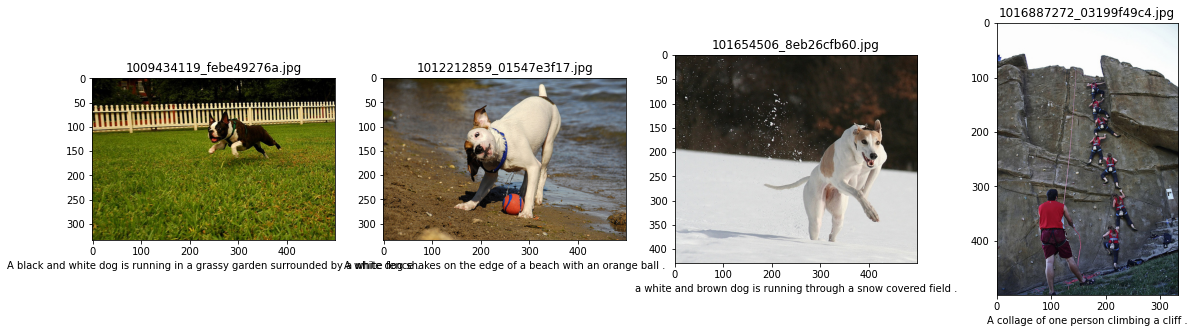

In [164]:
#Train Image
train_identifiers = train_identifier[:4]

fig = plt.figure(figsize=(20,5))
col = 4

for i in range(len(train_identifiers)):
  fig.add_subplot(1, col, i+1)
  plt.imshow(mpimg.imread('Images/' + train_identifiers[i]))
  plt.xlabel(specific_img[train_identifiers[i].split('.')[0]][0])
  # plt.axis('off')
  plt.title(train_identifiers[i])

plt.show()

In [165]:
test_identifier = list()
for i in test_data:
  x = i + '.jpg'
  test_identifier.append(x)

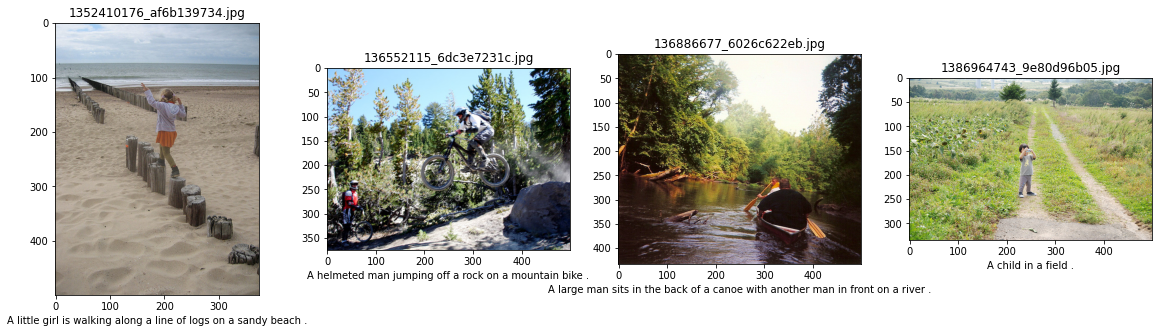

In [166]:
#Test Image
test_identifiers = test_identifier[10:14]

fig = plt.figure(figsize=(20, 5))
col = 4

for i in range(len(test_identifiers)):
  fig.add_subplot(1, col, i+1)
  plt.imshow(mpimg.imread('Images/' + test_identifiers[i]))
  plt.xlabel(specific_img[test_identifiers[i].split('.')[0]][0])
  # plt.axis('off')
  plt.title(test_identifiers[i])

plt.show()

# Preprocess Image

In [167]:
from tensorflow.keras.preprocessing.image import load_img
def preproces(path):
  #We set size 299 x 299 because we use Inception model, and that's the recomended size
  img = load_img(path, target_size = (299, 299))
  #Convert PIL image to numpy array of 3-dimension
  x = image.img_to_array(img)
  #Add one more dimension
  x = np.expand_dims(x, axis=0)
  #Rescale an image value from -1 to 1
  x = preprocess_input(x)
  # x = np.reshape(x, x.shape[1])
  return x

In [168]:
model = InceptionV3(weights='imagenet') 

In [169]:
new_model = Model(model.input, model.layers[-2].output)
# new_model.summary()

In [170]:
def encode_img(image):
  image = preproces(image) #preprocessing an image
  vector = new_model.predict(image)
  vector = np.reshape(vector, vector.shape[1])
  return vector

# Encode Train Images

In [171]:
start = time()
encoding_train = {}
for img in new_train_img:
  encoding_train[img[len(img_dir):]] = encode_img(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 183.099440574646


In [172]:
with open("/content/gdrive/MyDrive/Data Science/Dataset/Final Project/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

# Encode Test Images

In [173]:
#1
start = time()
encoding_test = {}
for img in new_test_img:
  encoding_test[img[len(img_dir):]] = encode_img(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 30.985501050949097


In [174]:
with open("/content/gdrive/MyDrive/Data Science/Dataset/Final Project/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [175]:
train_features = load(open("/content/gdrive/MyDrive/Data Science/Dataset/Final Project/Pickle/encoded_train_images.pkl", "rb"))
print('Trained Image:', len(train_features))

Trained Image: 1701


In [47]:
#list of all training captions
all_train_caps = []
for key, val, in train_data.items():
  for cap in val:
    all_train_caps.append(cap)
len(all_train_caps)

3607

In [48]:
#Filter the words
word_threshold = 10
word_count = {}
n = 0
for sent in all_train_caps:
  n += 1
  for w in sent.split(' '):
    word_count[w] = word_count.get(w, 0) + 1

vocab  = [w for w in word_count if word_count[w] >= word_threshold]
print("Filtered words {} => {}".format(len(word_count), len(vocab)))

Filtered words 2333 => 362


In [49]:
idx_to_word = {}
word_to_idx = {}

ix = 1
for w in vocab:
  word_to_idx[w] = ix
  idx_to_word[ix] = w
  ix += 1

vocab_size = len(idx_to_word) + 1 
vocab_size

363

In [51]:
#Making a list of descriptions
def to_lines(desc):
  all_desc = list()
  for key in desc.keys():
    [all_desc.append(d) for d in desc[key]]
  return all_desc

#Calculate max length of a description
def max_length(desc):
  line = to_lines(desc)
  return max(len(d.split()) for d in line)

max_len = max_length(train_data)
print("Maximum caption length:", max_len)

Maximum caption length: 36


In [180]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [181]:
# Load Glove vectors
glove_dir = 'Glove/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [182]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_idx.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(363, 200)

# Model

In [183]:
ip1 = Input(shape=(2048,))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation='relu')(fe1)
ip2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[ip1, ip2], outputs= output)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 36)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 36, 200)      72600       ['input_10[0][0]']               
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_9[0][0]']                
                                                                                            

In [184]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [185]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam')

In [186]:
num_pics_per_batch = 3
steps = len(train_data)//num_pics_per_batch

In [187]:
generator = data_generator(train_data, train_features, word_to_idx, max_len, num_pics_per_batch)
history = model.fit(generator, epochs=10, steps_per_epoch= steps, verbose = 1)
model.save('/saved_model/model_' + str(i) + '.h5')

Epoch 1/10
567/567 [==============================] - 103s 173ms/step - loss: 3.2566
Epoch 2/10
567/567 [==============================] - 97s 171ms/step - loss: 2.5368
Epoch 3/10
567/567 [==============================] - 97s 171ms/step - loss: 2.2753
Epoch 4/10
567/567 [==============================] - 99s 174ms/step - loss: 2.1130
Epoch 5/10
567/567 [==============================] - 103s 182ms/step - loss: 1.9926
Epoch 6/10
567/567 [==============================] - 98s 173ms/step - loss: 1.8710
Epoch 7/10
567/567 [==============================] - 102s 179ms/step - loss: 1.7726
Epoch 8/10
567/567 [==============================] - 102s 180ms/step - loss: 1.6712
Epoch 9/10
567/567 [==============================] - 96s 169ms/step - loss: 1.5754
Epoch 10/10
567/567 [==============================] - 95s 167ms/step - loss: 1.5013


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


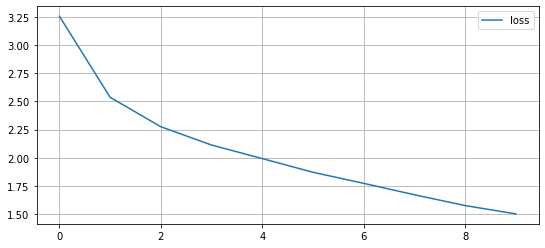

In [188]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(9,4))
plt.grid(True)
plt.show()

# Model Optimizer


In [189]:
model.optimizer.lr = 0.0001
num_pics_per_batch = 6
generator = data_generator(train_data, train_features, word_to_idx, max_len, num_pics_per_batch)
history = model.fit(generator, epochs=5, steps_per_epoch=steps, verbose=1)

Epoch 1/5
567/567 [==============================] - 98s 174ms/step - loss: 1.4707
Epoch 2/5
567/567 [==============================] - 98s 173ms/step - loss: 1.3684
Epoch 3/5
567/567 [==============================] - 102s 180ms/step - loss: 1.3250
Epoch 4/5
567/567 [==============================] - 101s 177ms/step - loss: 1.2891
Epoch 5/5
567/567 [==============================] - 102s 180ms/step - loss: 1.2582


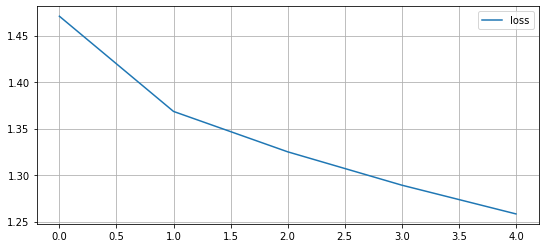

In [190]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(9,4))
plt.grid(True)
plt.show()

In [191]:
model.save('./saved_model/model_30.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Load Model

In [5]:
new_model = load_model('/content/gdrive/MyDrive/Data Science/Dataset/Final Project/saved_model/model_30.h5')

In [13]:
images = '/content/gdrive/MyDrive/Data Science/Dataset/Final Project/Images/'

In [8]:
with open('/content/gdrive/MyDrive/Data Science/Dataset/Final Project/Pickle/encoded_test_images.pkl', "rb") as encoded_pickle:
  encoding_test = load(encoded_pickle)

In [9]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(34):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], max_len)
        yhat = new_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

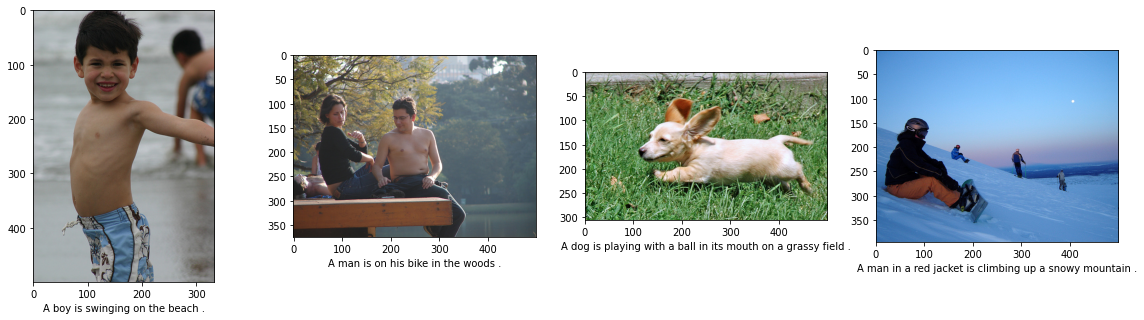

In [55]:
fig = plt.figure(figsize=(20, 5))
col = 4

for i in range(4):
  fig.add_subplot(1, col, i+1)
  pic = list(encoding_test.keys())[i]
  image = encoding_test[pic].reshape((1, 2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.xlabel(greedySearch(image))
  # plt.axis('off')

plt.show()